In [1]:
from collections import defaultdict
import inspect
import itertools
import os
import re
import subprocess
import sys

import nltk
from nltk.tokenize import WhitespaceTokenizer
import NERDA
import pandas as pd
import seaborn
import sqlite3

In [2]:
print(os.getcwd())
os.getcwd()
%ls

/Users/kaze7539/proj/bri/newa
README.md
__init__.py
__pycache__/
abe_bigram_naive_bayes_and_maxent.ipynb
abe_simple_naive_bayes.ipynb
conlleval.pl*
exploreNewa.ipynb
for_ml/
good_length.txt
just_ec.conll
ki.txt
ki_true.txt
lined_up.txt
new_dedup.txt
newfile.txt
rerun_using_bri_partitions.ipynb
results.db
run_all_experiments.ipynb
tmp.txt
tmp.txt~
tmp1.txt
tmp1.txt~
util.py
util.py~


In [3]:
sys.path.append(".")
print(sys.path)
import util # library/module with recorded experiments and helper functions

['/Users/kaze7539/proj/bri/newa', '/usr/local/opt/python@3.8/Frameworks/Python.framework/Versions/3.8/lib/python38.zip', '/usr/local/opt/python@3.8/Frameworks/Python.framework/Versions/3.8/lib/python3.8', '/usr/local/opt/python@3.8/Frameworks/Python.framework/Versions/3.8/lib/python3.8/lib-dynload', '', '/Users/kaze7539/.virtualenvs/bri/lib/python3.8/site-packages', '/Users/kaze7539/.virtualenvs/bri/lib/python3.8/site-packages/IPython/extensions', '/Users/kaze7539/.ipython', '.']


In [4]:
# here are all the experiments that have been saved in util.py
experiments = sorted([item for item in dir(util) if item.startswith("experiment")])
print(experiments)


['experiment_001_naive_bayes_unigram', 'experiment_002_naive_bayes_pseudo_bigram_dishonest', 'experiment_002_naive_bayes_pseudo_bigram_honest', 'experiment_003_maxent_pseudo_bigram', 'experiment_004_maxent_bigram', 'experiment_005_bri_nerda', 'experiment_011_naive_bayes_unigram', 'experiment_012_naive_bayes_pseudo_bigram_dishonest', 'experiment_012_naive_bayes_pseudo_bigram_honest', 'experiment_013_maxent_pseudo_bigram', 'experiment_014_maxent_bigram', 'experiment_016_maxent_trigram']


In [5]:
# create a database to store the results
connection = sqlite3.connect("results.db")
cursor = connection.cursor()
cursor.execute('''
    create table if not exists conlleval
    (
      experiment_name text not null,
      num_tokens integer not null,
      num_phrases integer not null,
      num_found integer not null,
      num_correct integer not null,
      accuracy real not null,
      precision real not null,
      recall real not null,
      fb1 real not null,
      constraint conlleval_pk primary key (experiment_name)
    );
    ''')

In [12]:
for experiment_name in experiments:
    print(experiment_name)
    cursor.execute("select * from conlleval where experiment_name = ?", (experiment_name, ))
    results = cursor.fetchone()
    if results: # if you want to rerun all the experiments delete the database file
        print("results cached", results)
    else:
        #results = globals()[experiment_name]()
        results = getattr(util, experiment_name)() # getattr gets the experiment from util module, () runs it
        cursor.execute("""
            insert into conlleval
            (experiment_name,  num_tokens, num_phrases, num_found, num_correct, accuracy, precision, recall, fb1)
            values (
            :experiment_name,
            :num_tokens,
            :num_phrases,
            :num_found,
            :num_correct,
            :accuracy,
            :precision,
            :recall,
            :fb1
            );
        """, results)
        print(results)
        connection.commit()

experiment_001_naive_bayes_unigram
results cached ('experiment_001_naive_bayes_unigram', 711, 33, 126, 0, 52.88, 0.0, 0.0, 0.0)
experiment_002_naive_bayes_pseudo_bigram_dishonest
results cached ('experiment_002_naive_bayes_pseudo_bigram_dishonest', 711, 33, 40, 21, 97.33, 52.5, 63.64, 57.53)
experiment_002_naive_bayes_pseudo_bigram_honest
results cached ('experiment_002_naive_bayes_pseudo_bigram_honest', 711, 33, 33, 19, 84.39, 57.58, 57.58, 57.58)
experiment_003_maxent_pseudo_bigram
results cached ('experiment_003_maxent_pseudo_bigram', 711, 33, 41, 26, 83.12, 63.41, 78.79, 70.27)
experiment_004_maxent_bigram
results cached ('experiment_004_maxent_bigram', 711, 33, 37, 27, 89.73, 72.97, 81.82, 77.14)
experiment_005_bri_nerda
results cached ('experiment_005_bri_nerda', 242, 13, 16, 10, 96.28, 62.5, 76.92, 68.97)
experiment_011_naive_bayes_unigram
processed 268 tokens with 13 phrases; found: 46 phrases; correct: 1.
accuracy:  63.81%; precision:   2.17%; recall:   7.69%; FB1:   3.39
    

             9          -0.11612        0.997
            10          -0.10558        0.997
            11          -0.09686        0.997
            12          -0.08953        0.997
            13          -0.08328        0.997
            14          -0.07788        0.997
            15          -0.07317        0.997
            16          -0.06903        0.997
            17          -0.06536        0.997
            18          -0.06208        0.997
            19          -0.05913        0.997
            20          -0.05647        0.997
            21          -0.05406        0.997
            22          -0.05186        0.997
            23          -0.04984        0.997
            24          -0.04799        0.997
            25          -0.04628        0.997
            26          -0.04470        0.997
            27          -0.04324        0.997
            28          -0.04187        0.997
            29          -0.04060        0.997
            30          -0.03941  

            74          -0.01581        0.998
            75          -0.01564        0.998
            76          -0.01548        0.998
            77          -0.01532        0.998
            78          -0.01516        0.998
            79          -0.01501        0.998
            80          -0.01486        0.998
            81          -0.01472        0.998
            82          -0.01458        0.998
            83          -0.01444        0.998
            84          -0.01431        0.998
            85          -0.01417        0.998
            86          -0.01405        0.998
            87          -0.01392        0.998
            88          -0.01380        0.998
            89          -0.01368        0.998
            90          -0.01356        0.998
            91          -0.01345        0.998
            92          -0.01333        0.998
            93          -0.01322        0.998
            94          -0.01312        0.998
            95          -0.01301  

In [13]:
# read experiment data into pandas dataframe
df = pd.read_sql_query("SELECT * from conlleval", connection)
#print(df.melt.__doc__)

In [14]:
df

,experiment_name,num_tokens,num_phrases,num_found,num_correct,accuracy,precision,recall,fb1
0,experiment_001_naive_bayes_unigram,711,33,126,0,52.88,0.00,0.00,0.00
1,experiment_002_naive_bayes_pseudo_bigram_disho...,711,33,40,21,97.33,52.50,63.64,57.53
2,experiment_002_naive_bayes_pseudo_bigram_honest,711,33,33,19,84.39,57.58,57.58,57.58
3,experiment_003_maxent_pseudo_bigram,711,33,41,26,83.12,63.41,78.79,70.27
4,experiment_004_maxent_bigram,711,33,37,27,89.73,72.97,81.82,77.14
5,experiment_005_bri_nerda,242,13,16,10,96.28,62.50,76.92,68.97
6,experiment_011_naive_bayes_unigram,268,13,46,1,63.81,2.17,7.69,3.39
7,experiment_012_naive_bayes_pseudo_bigram_disho...,268,13,17,8,97.39,47.06,61.54,53.33
8,experiment_012_naive_bayes_pseudo_bigram_honest,268,13,13,8,85.45,61.54,61.54,61.54
9,experiment_013_maxent_pseudo_bigram,268,13,19,10,80.97,52.63,76.92,62.50


In [15]:
df.melt(id_vars=['experiment_name'], value_vars=["precision", "recall", "fb1"])

,experiment_name,variable,value
0,experiment_001_naive_bayes_unigram,precision,0.00
1,experiment_002_naive_bayes_pseudo_bigram_disho...,precision,52.50
2,experiment_002_naive_bayes_pseudo_bigram_honest,precision,57.58
3,experiment_003_maxent_pseudo_bigram,precision,63.41
4,experiment_004_maxent_bigram,precision,72.97
5,experiment_005_bri_nerda,precision,62.50
6,experiment_011_naive_bayes_unigram,precision,2.17
7,experiment_012_naive_bayes_pseudo_bigram_disho...,precision,47.06
8,experiment_012_naive_bayes_pseudo_bigram_honest,precision,61.54
9,experiment_013_maxent_pseudo_bigram,precision,52.63


In [16]:
import seaborn as sbn

<AxesSubplot:xlabel='value', ylabel='experiment_name'>

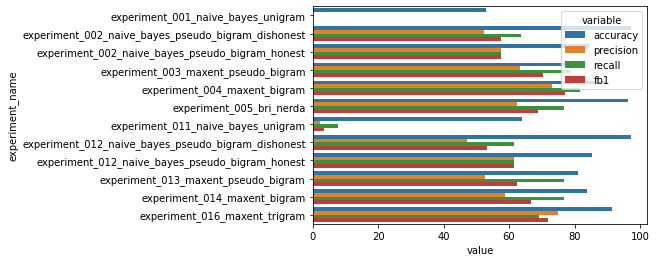

In [17]:
sbn.barplot(
    data=df.melt(id_vars=['experiment_name'], value_vars=["accuracy","precision", "recall", "fb1"]), 
    y="experiment_name", 
    x="value", 
    hue="variable"
)